# Micro Risks and Pareto Improving Policies 

In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__, ".."))
using Revise
using MicroRisks
using ProgressMeter
using CairoMakie
using LaTeXStrings
using StatsBase
using Polyester
using Roots

  Activating project at `C:\Users\amado\Documents\GitHub\micro_risks_pareto_improving_policies`


In [7]:
_φ = 1/Base.MathConstants.φ

0.6180339887498948

In [3]:
ProgressMeter.ijulia_behavior(:clear);

## Benchmark Economy

In [4]:
# Household
h = let 
    # labor supply
    v = GHH(θ = 1.0, ν = 0.2)
 
    # income process
    ar1 = 0.9695
    sigmaP = sqrt(0.0384)/(1 + v.ν)
    sigmaIID = sqrt(0.0522)/(1 + v.ν)
    P, z_vals = calibration(5, 2 , ar1, sigmaP, sigmaIID)

    # consumption preferences
    ies = 1 
    crra = 5.5
    β = 0.993
    u = EZ(ies = ies, ra = crra, β = β)

    Household(u = u, a_grid = grid(stop = 10.0, length = 500, scale = :log),
        v = v, P = P, z_grid = z_vals)
end

EZ(ra=5.5, ies=1.0, β=0.993), v=GHH(θ=1.0, ν=0.2), z_grid=[0.17222630362336608..3.6217622755477725], P=[..], a_grid = 0.0..500pts..10.000000000000002

In [5]:
# Technology
t = let
    δ = 0.1
    A = 0.2
    α = 0.3
    μ = 1.4
    CobbDouglasTechnology(α = α, A = A^((1 - α)), δ = δ, μ = μ)
end

α=0.3, A=0.32413131933855255, δ=0.1

Initial equilibrium (laissez faire)

In [6]:
@time e_init = stationary_laissez_faire(h, t; r_range = (-0.02, 0.0), verbose = true)

Progress:  10 	 Time: 0:00:40
  r:      -0.01699696069678162
  error:  5.737378128145565e-9


 44.615325 seconds (11.46 M allocations: 834.304 MiB, 0.69% gc time, 11.70% compilation time)


Stationary Equilibrium. Household: EZ(ra=5.5, ies=1.0, β=0.993), v=GHH(θ=1.0, ν=0.2), z_grid=[0.17222630362336608..3.6217622755477725], P=[..], a_grid = 0.0..500pts..10.000000000000002, Technology: α=0.3, A=0.32413131933855255, δ=0.1, r=-0.01699696069678162, w=0.15015100341943483, T=0.0, a=0.5601165104689236, k=0.5601165047315455, b=0.0, n=0.7224718192241156

## Constant-K Transition

Transition to a higher debt level

In [8]:
# b = 0.6 y0 
b_target = y(e_init) * 0.60

0.13017584231851856

Final equilibrium with higher debt and same k

In [9]:
@time e_final = stationary_equilibrium_given_k_b(e_init, e_init.k, b_target; r_range = (-0.02, 0.0), verbose = true)

Progress:  13 	 Time: 0:01:06
  r:      -0.01396496854305763
  error:  -2.001294963083211e-10


 66.690933 seconds (1.06 M allocations: 59.977 MiB, 0.62% compilation time)


Stationary Equilibrium. Household: EZ(ra=5.5, ies=1.0, β=0.993), v=GHH(θ=1.0, ν=0.2), z_grid=[0.17222630362336608..3.6217622755477725], P=[..], a_grid = 0.0..500pts..10.000000000000002, Technology: α=0.3, A=0.32413131933855255, δ=0.1, r=-0.01396496854305763, w=0.15015100341943483, T=0.00011963269552681122, a=0.6902923468499346, k=0.5601165047315455, b=0.13017584231851856, n=0.7224718192241156

Debt policy and capital (constant) along the transition

In [10]:
b_path = let   # Smooth path of increasing debt  
    T = 100  # period of adjustment of debt
    H = 50   # debt level no longer moving
    ρB = 0.9
    b_list = Array{Float64,1}(undef, T + H)
    b_list[1] = 0.0
    b_list[2] = y(e_init) * 0.05
    b_list[T:end] .= b_target
    for i in 3:T-1
        b_list[i] = b_list[2] * ρB^(i-2) + (1 - ρB^(i-2)) * b_target
    end
    b_list
end;

In [11]:
k_path = [e_init.k for _ in b_path];

Solving the transition 

In [12]:
@time path = solve_transition(e_init, e_final; k_path, b_path);

Progress:  6 	 Time: 0:00:03
  error:  5.41712397161831e-10


 15.589895 seconds (6.87 M allocations: 579.458 MiB, 1.22% gc time, 25.24% compilation time)


Implied aggreate savings elasticities: 

In [13]:
elas = b_path ./ (path.r .- e_init.r) ./ (e_init.a) .* (1 + e_init.r)
( elas[2], elas[end] )

(4.620639123402305, 75.35018173319251)

## Transition Towards Golden Rule

In [14]:
k_golden = golden_rule_k(t; e_init.n)

0.6941489958749973

In [15]:
@time e_final_2 = let 
    b_target = y(e_init) * 0.60
    stationary_equilibrium_given_k_b(e_init, k_golden, b_target; r_range = (-0.02, 0.0), verbose = true)
end 

Progress:  13 	 Time: 0:01:10
  r:      -0.011275508662005015
  error:  -2.605529403343354e-10


 70.090085 seconds (58.04 k allocations: 6.979 MiB)


Stationary Equilibrium. Household: EZ(ra=5.5, ies=1.0, β=0.993), v=GHH(θ=1.0, ν=0.2), z_grid=[0.17222630362336608..3.6217622755477725], P=[..], a_grid = 0.0..500pts..10.000000000000002, Technology: α=0.3, A=0.32413131933855255, δ=0.1, r=-0.011275508662005015, w=0.15015100341943483, T=0.0007944159499390646, a=0.824324837932963, k=0.6941489958749973, b=0.13017584231851856, n=0.7224718192241156

Debt policy is same as above. Capital along the transition is:

In [16]:
k_path_2 = let 
    ρK = 0.95
    k_path_2 = similar(k_path)
    for i in eachindex(k_path_2)
        k_path_2[i] = e_init.k * ρK^(i-1) + (1 - ρK^(i-1)) * k_golden
    end
    k_path_2
    end;

In [17]:
@time path_2 = solve_transition(e_init, e_final_2; k_path = k_path_2, b_path);

Progress:  8 	 Time: 0:00:03
  error:  4.400161221496113e-9


 12.433590 seconds (123.77 k allocations: 205.300 MiB, 2.38% gc time)


## Transition To Golden Rule Without Debt 

In [18]:
@time e_final_3 = let 
    b_target = 0.0
    stationary_equilibrium_given_k_b(e_init, k_golden, b_target; r_range = (-0.02, 0.0), verbose = true)
end 

Progress:  13 	 Time: 0:01:03
  r:      -0.013454060947211533
  error:  -1.9653989546952744e-10


 63.849678 seconds (54.13 k allocations: 6.649 MiB)


Stationary Equilibrium. Household: EZ(ra=5.5, ies=1.0, β=0.993), v=GHH(θ=1.0, ν=0.2), z_grid=[0.17222630362336608..3.6217622755477725], P=[..], a_grid = 0.0..500pts..10.000000000000002, Technology: α=0.3, A=0.32413131933855255, δ=0.1, r=-0.013454060947211533, w=0.15015100341943483, T=0.0008388569935301043, a=0.6941489956784574, k=0.6941489958749973, b=0.0, n=0.7224718192241156

In [19]:
b_path_3 = [0.0 for _ in k_path_2];

In [20]:
@time path_3 = solve_transition(e_init, e_final_3; k_path = k_path_2, b_path = b_path_3);

Progress:  7 	 Time: 0:00:03
  error:  3.1998421690104806e-9


 12.311247 seconds (121.79 k allocations: 205.081 MiB, 0.42% gc time)


## Statistics

In [21]:
statistics = let
    iobuffer = IOBuffer()

    println(iobuffer, "INITIAL STEADY STATE")
    println(iobuffer,"=====================")
    summary_statics(e_init; iobuffer)


    println(iobuffer, "\nFINAL STEADY STATE -- CONSTANT K AND DEBT")
    println(iobuffer, "=====================")
    summary_statics(e_final;
        laissez_faire = e_init,
        path = path, iobuffer)


    println(iobuffer, "\nFINAL STEADY STATE -- GOLDEN K AND DEBT")
    println(iobuffer, "=====================")
    summary_statics(e_final_2;
        laissez_faire = e_init,
        path = path_2, iobuffer)

    String(take!(iobuffer))
end
println("\n", statistics, "\n")


INITIAL STEADY STATE

FISCAL
debt: 0.0
debt over y (%): 0.0
transfer over y (%): 0.0
interest rate: -0.01699696069678162

AGGREGATES
capital over y: 2.581661058252424

HOUSEHOLDS
standard deviation of log c (*100): 68.03300565719124

mass of constrained households (%): 3.1822868795829837
mean wealth (over y): 2.581661084696861
median wealth (over y): 1.239457505838162
share of wealth per asset quintiles:
   [0.6626257844819219, 3.835585084652982, 9.846035266262895, 23.057130735022593, 62.59862312957961]

FINAL STEADY STATE -- CONSTANT K AND DEBT

FISCAL
debt: 0.13017584231851856
debt over y (%): 60.0
transfer over y (%): 0.055140505363855445
interest rate: -0.01396496854305763

AGGREGATES
capital over y: 2.581661058252424

HOUSEHOLDS
standard deviation of log c (*100): 66.1223958871915

mass of constrained households (%): 2.3438522385637475
mean wealth (over y): 3.1816610573299973
median wealth (over y): 1.6542684708525726
share of wealth per asset quintiles:
   [0.7975190545527341, 4

##  Plots

In [37]:
function do_plots(path, laissez_faire; legend_pos = :rt, last_plot = false)
    t = laissez_faire.t
    h = laissez_faire.h
    n = laissez_faire.n

    ylist  = map(k -> output(t; k , n), path.k)
    size = (400, 300)
    y0 = y(laissez_faire)

    path = path[1:100]

    #################
    #  B

    fontsize_theme = Theme(fontsize = 15)
    set_theme!(fontsize_theme)

    fig = Figure(resolution = (800, _φ * 800)) 


    ax = Axis(fig[1, 1], title = L"$b/y_{0}$", ylabel = LaTeXString("%"), titlesize = 20)
    xlims!(ax,  (0, 100))
    ylims!(ax,  (0, 100))
    ax.xticks = 0:25:100
    
    if last_plot  
        lines!(ax, 100 .* path.b ./ y0, color = :blue, linewidth = 4)
    else
        lines!(ax, 100 .* path.b ./ y0, color = :blue)
    end

    ##################
    # K

    ax = Axis(fig[1, 2], title = L"$k/y_{0}$", titlesize = 20)
    xlims!(ax,  (0, 100))
    ylims!(ax, (0, 1.1 * maximum(path.k ./ y0)))
    ax.xticks = 0:25:100
   
    lines!(ax, path.k ./ y0, color = :blue)

    # ##################
    # # TRANSFERS AND B 

    ax = Axis(fig[1, 3], title = LaTeXString("\$T\$ and  \$b^\\prime - R b\$"), ylabel = LaTeXString("%"),  titlesize = 20)
    xlims!(ax,  (0, 100))

    ser = 100 .* path.T ./ y0
    ax.xticks = 0:25:100

    band!(1:length(ser), ser, [0.0 for _ in ser], color = (:blue, 0.2), label = L"$T/y_0$")
    lines!(ser, color = :blue)
    lines!([100 * (bprime - (1 + r) * b) / y0 for (b, bprime, r) in zip(path.b, path.b[2:end], path.r, ylist)], label = L"$\frac{b^\prime - R b}{y_0}$", color = :red, linestyle = :dash)

    axislegend(position = legend_pos)

    # ######################
    # #  R

    ax = Axis(fig[2, 1], title = L"$r$", ylabel = LaTeXString("%"), titlesize = 20) 
    xlims!(ax,  (0, 100))
    ax.xticks = 0:25:100
   
    lines!(ax, path.r .* 100, color = :blue)

    # ######################
    # # CONSUMPTION
   
    ax = Axis(fig[2, 2], title = L"$c/c_0$", ylabel = LaTeXString("%"), titlesize = 20)
    xlims!(ax,  (0, 100))
    ylims!(ax, (-5, 5))
    ax.xticks = 0:25:100

    agg_c = [y + (1 - t.δ) * k - kprime for (y, k, kprime) in zip(ylist, path.k, path.k[2:end])]
    c0 = y(laissez_faire) - t.δ * laissez_faire.k

    band!(ax, 1:length(agg_c), 100 .* (agg_c ./ c0  .- 1), [0.0 for _ in agg_c], color = (:blue, 0.2))
    lines!(ax, 100 .* (agg_c ./ c0  .- 1), color = :blue)
    
    # #########################
    # # STD DEV

    ax = Axis(fig[2, 3],  title = L"$\sigma(\log c) - \sigma(\log c_0)$", ylabel = LaTeXString("%"), titlesize = 20)
    xlims!(ax,  (0, 100))
    ax.xticks = 0:25:100
   
    std_con = map(path) do alloc
        con = reshape(consumption_alloc(h; R = 1 + alloc.r, laissez_faire.w, alloc.T, alloc.a_pol), 1, :)[1, :]
        allpdf = reshape(alloc.pdf, 1, :)[1, :]
        100 * StatsBase.std(log.(con), StatsBase.ProbabilityWeights(allpdf))
    end

    con_init = consumption_alloc(h; R = 1 + laissez_faire.r, laissez_faire.w, laissez_faire.T, laissez_faire.ws.a_pol)
    con_init_ = reshape(con_init,1, :)[1, :]
    allpdf_init = reshape(laissez_faire.ws.pdf, 1, :)[1, :]
    std_con_init = 100 * StatsBase.std(log.(con_init_), StatsBase.ProbabilityWeights(allpdf_init))

    band!(ax, 1:length(std_con), std_con .- std_con_init, [0 for _ in std_con], color = (:blue, 0.2))
    lines!(ax, std_con .- std_con_init, color = :blue)
    
    return fig
end

do_plots (generic function with 1 method)

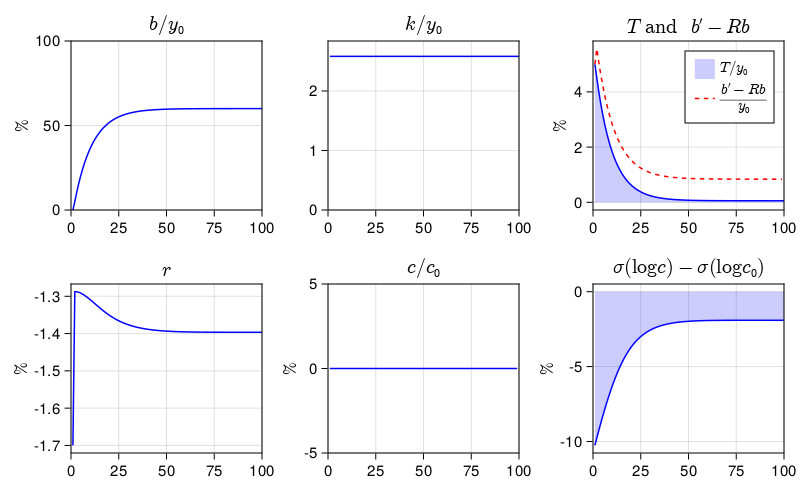

In [38]:
f1 = do_plots(path, e_init)

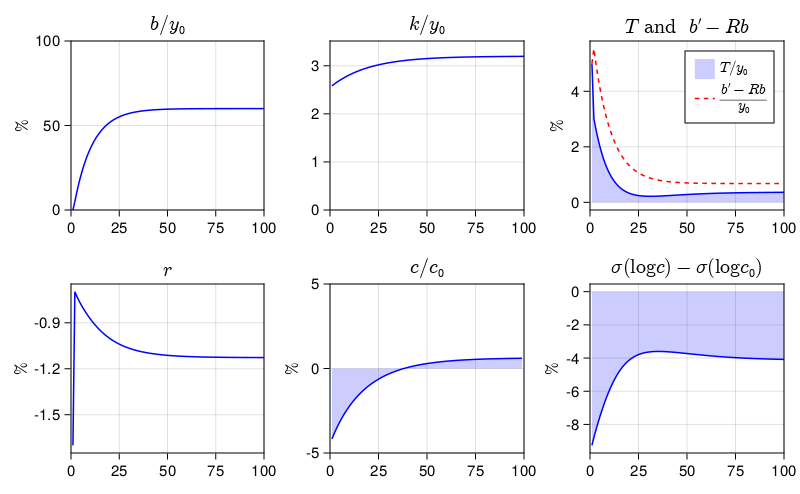

In [24]:
f2 = do_plots(path_2, e_init)

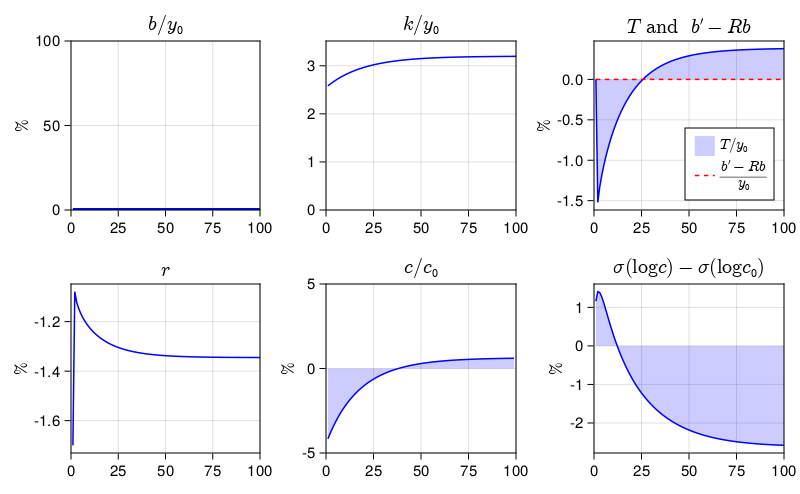

In [25]:
f3 = do_plots(path_3, e_init, legend_pos = :rb, last_plot = true)

##  Steady State Segniorage Plots

In [26]:
# Increasing the amax so that it doesn't bind
h_2 = let 
    v = GHH(θ = 1.0, ν = 0.2)

    ar1 = 0.9695
    sigmaP = sqrt(0.0384)/(1 + v.ν)
    sigmaIID = sqrt(0.0522)/(1 + v.ν)
    P, z_vals = calibration(5, 2 , ar1, sigmaP, sigmaIID)

    ies = 1 
    crra = 5.5
    β = 0.993
    u = EZ(ies = ies, ra = crra, β = β)
    Household(u = u, a_grid = grid(stop = 50, length = 500, scale = :log), 
        v = v, P = P, z_grid = z_vals)
end

EZ(ra=5.5, ies=1.0, β=0.993), v=GHH(θ=1.0, ν=0.2), z_grid=[0.17222630362336608..3.6217622755477725], P=[..], a_grid = 0.0..500pts..49.999999999999986

In [27]:
# Solve laissez-faire economy
@time e_init_2 = stationary_laissez_faire(h_2, t; r_range = (-0.02, 0.0), verbose = true)

Progress:  10 	 Time: 0:00:39
  r:      -0.01706912103131807
  error:  5.645151457400743e-9


 39.423423 seconds (43.98 k allocations: 5.397 MiB)


Stationary Equilibrium. Household: EZ(ra=5.5, ies=1.0, β=0.993), v=GHH(θ=1.0, ν=0.2), z_grid=[0.17222630362336608..3.6217622755477725], P=[..], a_grid = 0.0..500pts..49.999999999999986, Technology: α=0.3, A=0.32413131933855255, δ=0.1, r=-0.01706912103131807, w=0.15020698250372322, T=0.0, a=0.5608546960501386, k=0.5608546904049871, b=0.0, n=0.7225256813763292

In [28]:
r_range_ = [e_init_2.r, 0.0]
b_range  =  2.6:-0.2:0.2
out = Array{Any}(undef, length(b_range))
Polyester.disable_polyester_threads() do
    p = Progress(length(b_range))
    @time Threads.@threads for i in eachindex(b_range)
        b = b_range[i]
        sol = stationary_equilibrium_given_k_b(
            e_init_2,
            e_init_2.k,
            b * y(e_init_2);
            r_range = r_range_,
            verbose = false,
            hh_problem_kwargs = (;
                value_tol = 1e-7, 
                policy_tol = 1e-7, 
                pdf_tol = 1e-7)
        )
        out[i] = sol
        next!(p)
    end
end
# out = @showprogress map(f, 2.6:-0.2:0.2)
push!(out, e_init_2);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:43


223.558897 seconds (11.37 M allocations: 1.137 GiB, 0.21% gc time, 2.52% compilation time)


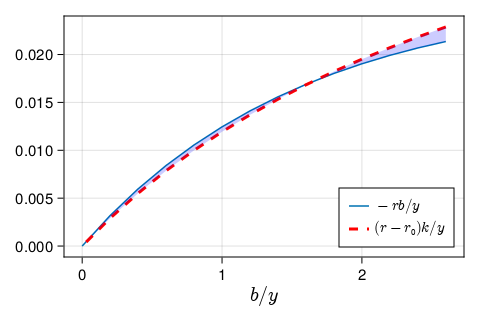

In [34]:
f4 = let
    b_y = [eq.b / y(eq) for eq in out]
    rb = [-eq.r * eq.b / y(eq) for eq in out]
    deltark = [(eq.r - e_init_2.r) * eq.k / y(eq) for eq in out]
    fig = Figure(fontsize = 15, resolution = (.8 * 600, .8 * 400))
    ax = Axis(fig[1, 1], xlabel = L"b/y", xlabelsize = 20)
    lines!(ax, b_y, rb,  label=L"$- r  b / y$")
    lines!(ax, b_y, deltark, color = :red, linestyle = :dash, linewidth = 3, label = L"$(r - r_0)  k / y")
    band!(ax, b_y, deltark, rb, color = (:blue, 0.2))
    axislegend(position = :rb)
    fig 
end

## Present Value of Elasticities

### Partial Equilibrium

In [29]:
cap_s = 50   # time of policy change
cap_t = 1_000  # total period of integration

1000

The interest rate is fixed.

In [30]:
function pv_PE(;R, ies_range, μ_range, 
    T = 0.0, w = 1.0, 
    cap_s = cap_s, cap_t = cap_t, Δ = 1e-4,
    value_tol = 1e-7, policy_tol = 1e-7, pdf_tol = 1e-7
)
    r = R - 1
    v = GHH(θ = 1.0, ν = 0.2)
    a_grid = grid(; stop = 250.0, length = 200, scale = :log)

    ar1 = 0.9695
    sigmaP = sqrt(0.0384)/(1 + v.ν)
    sigmaIID = sqrt(0.0522)/(1 + v.ν)
    P, z_vals = calibration(5, 2 , ar1, sigmaP, sigmaIID)

    δ = 0.1
    crra = 5.5 
    β = 0.993
    
    lst = similar(ies_range, Any)
    
    Polyester.disable_polyester_threads() do
        p = Progress(length(ies_range))
        Threads.@threads for i in eachindex(ies_range)
            ies = ies_range[i]
            u = EZ(ies = ies, ra = crra, β = β)
            h = Household(u = u, a_grid = a_grid, v = v, P = P, z_grid = z_vals)
            ws = stationary(h; R, T, w, verbose = false, value_tol, policy_tol, pdf_tol)

            !is_pol_valid(ws.a_pol, h) && @warn "R =$R, ies = $ies. Not valid policy!"

            cache = JacobianCache(ws; R, T, w, cap_s, cap_t, ΔR = 1e-4, ΔT = 0.0) # compute cache only once

            pv_lst = map(μ_range) do μ 
                Rk = μ * (r + δ) + 1 - δ
                return (; 
                    pv = Rk > 1 ? pv_elasticities!(cache, cap_s; Rk) : nothing, 
                    r, μ, ies, crra, β, dyn_efficient = Rk > 1)
            end
            lst[i] = pv_lst
            next!(p)
        end 
    end 
    
    return lst
end 

pv_PE (generic function with 1 method)

In [31]:
ies_range = range(0.05, 1.5, length = 100)
μ_range = range(1.001, 3.0, length = 75)
lst_PE = pv_PE(;R = 1 + e_init.r, ies_range, μ_range);

Progress: 100%|█████████████████████████████████████████| Time: 0:04:12


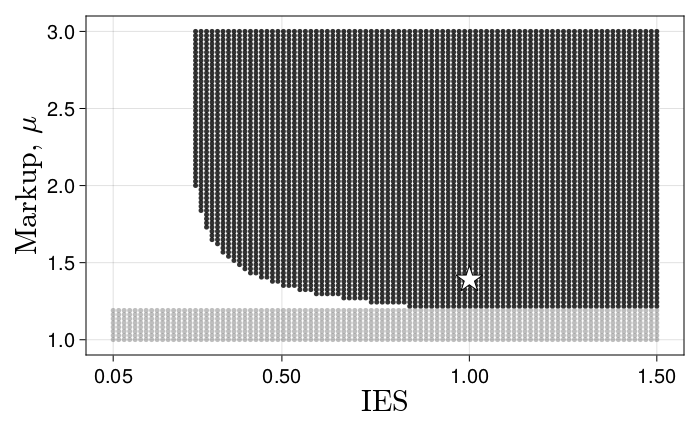

In [32]:
fig_pv_PE = let lst = lst_PE
    
    flattened_lst = collect(Base.Iterators.flatten(lst))

    dyn_eff = let 
        tmp = filter(flattened_lst) do x 
            !isnothing(x.pv) && x.pv > 1
        end
        [(x.ies, x.μ) for x in tmp]
    end

    bad = let 
        tmp = filter(flattened_lst) do x 
            !isnothing(x.pv) && x.pv <= 1
        end
        [(x.ies, x.μ) for x in tmp]
    end

    dyn_ine = let 
        tmp = filter(flattened_lst) do x 
            !x.dyn_efficient
        end
        [(x.ies, x.μ) for x in tmp]
    end

    fig = Figure(fontsize = 20,  resolution = (.7 * 1000, .7 * 1000 * _φ))
    ax = Axis(fig[1, 1], xlabel = LaTeXString("IES"), ylabel = LaTeXString("Markup, \$\\mu\$"), 
        xlabelsize = 30, ylabelsize = 30) 
    ax.xticks = [0.05, 0.5, 1., 1.5]
    plot!(ax, [x[1] for x in dyn_eff], [x[2] for x in dyn_eff], color = (:black, 0.8), markersize = 5)
    plot!(ax, [x[1] for x in dyn_ine], [x[2] for x in dyn_ine], color = (:gray, 0.5), markersize = 5)

    scatter!(ax, [1.0], [1.4], color = :white, markersize = 35, strokecolor = :black, strokewidth= 1, marker = :star5)
    fig
end

### General Equilibrium

The equilibrium interest rate is solved for each parameterization.

In [33]:
function pv_GE(
    μ_range;  
    ies = 1, crra = 5.5, β = 0.993,
    r_range = (-0,07, 0.00), verbose = true, cap_s = cap_s, cap_t = cap_t, Δ = 1e-4,
    value_tol = 1e-7, policy_tol = 1e-7, pdf_tol = 1e-7 
)
    h = let 
        v = GHH(θ = 1.0, ν = 0.2)

        ar1 = 0.9695
        sigmaP = sqrt(0.0384)/(1 + v.ν)
        sigmaIID = sqrt(0.0522)/(1 + v.ν)
        P, z_vals = calibration(5, 2 , ar1, sigmaP, sigmaIID)

        u = EZ(ies = ies, ra = crra, β = β)
        Household(u = u, a_grid = grid(stop = 200.0, length = 200), # Extending a_max given w normalization
            v = v, P = P, z_grid = z_vals) 
    end

    δ = 0.1
    α = 0.3

    w = 1.0  # Normalizing the wage
    T = 0.0
    ws = HouseholdWorkspace(; h, R = 1 + r_range[1], T, w)
    n = labor_supply(h; w)

    f = function (r) 
        stationary!(ws; R = 1 + r, T, w, verbose = false, value_tol, policy_tol, pdf_tol)
        aa = asset_supply(h.a_grid, ws.pdf) 
        dis =  aa / n * (1 - α) - α / (r + δ)
        return dis
    end 

    r = find_zero(f, r_range, A42(), atol = 1e-6)
    stationary!(ws; R = 1 + r, T, w, verbose = false)
    !is_pol_valid(ws.a_pol, h) && @warn "Not valid policy!"
    
    cache = JacobianCache(ws; R = 1 + r, T, w, cap_s, cap_t, ΔR = 1e-4, ΔT = 0.0) # compute cache only once

    pv_lst = map(μ_range) do μ 
        Rk = μ * (r + δ) + 1 - δ
        return (; 
            pv = Rk > 1 ? pv_elasticities!(cache, cap_s; Rk) : nothing, 
            r, μ, ies, crra, β, dyn_efficient = Rk > 1)
    end 
    return pv_lst
end 

pv_GE (generic function with 1 method)

In [34]:
ϵ_range = range(0.05, 1.5, length = 100)
μ_range = range(1.001, 3.0, length = 75)
lst_GE = similar(ϵ_range, Any)
Polyester.disable_polyester_threads() do
    p = Progress(length(ϵ_range))
    @time Threads.@threads for i in eachindex(collect(reverse(ϵ_range)))
        lst_GE[i] =  pv_GE(μ_range; ies = ϵ_range[i], r_range = (-0.07, 0.00))
        next!(p)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:25:20


1520.117993 seconds (28.44 M allocations: 22.765 GiB, 0.15% gc time, 0.14% compilation time)


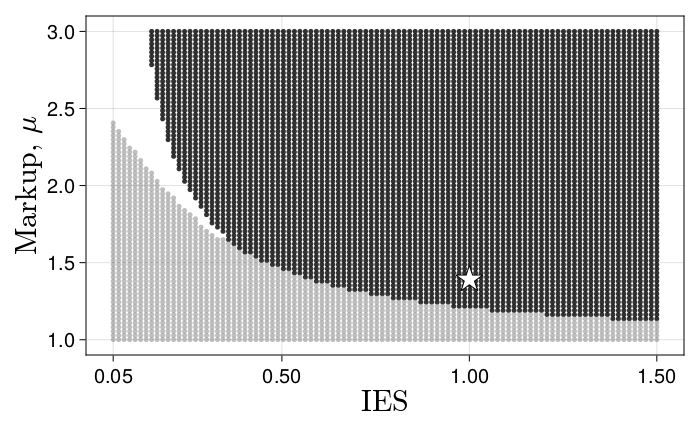

In [35]:
fig_pv_GE = let lst = lst_GE
    flattened_lst = collect(Base.Iterators.flatten(lst))

    dyn_eff = let 
        tmp = filter(flattened_lst) do x 
            !isnothing(x.pv) && x.pv > 1
        end
        [(x.ies, x.μ) for x in tmp]
    end

    bad = let 
        tmp = filter(flattened_lst) do x 
            !isnothing(x.pv) && x.pv <= 1
        end
        [(x.ies, x.μ) for x in tmp]
    end

    dyn_ine = let 
        tmp = filter(flattened_lst) do x 
            !x.dyn_efficient
        end
        [(x.ies, x.μ) for x in tmp]
    end

    fig = Figure(fontsize = 20, resolution = (.7 * 1000, .7 * 1000 * _φ))
    ax = Axis(fig[1, 1], xlabel = LaTeXString("IES"), ylabel = LaTeXString("Markup, \$\\mu\$"), 
        xlabelsize = 30, ylabelsize = 30) 
    ax.xticks = [0.05, 0.5, 1., 1.5]
    plot!(ax, [x[1] for x in dyn_eff], [x[2] for x in dyn_eff], color = (:black, 0.8), markersize = 5)
    plot!(ax, [x[1] for x in dyn_ine], [x[2] for x in dyn_ine], color = (:gray, 0.5), markersize = 5)
    
    scatter!(ax, [1.0], [1.4], color = :white, markersize = 35, strokecolor = :black, strokewidth= 1, marker = :star5)

    fig 
end 

## Saving the Figures and Statistics

In [39]:
save(joinpath(@__DIR__, "..", "output", "figures", "transition_efficient_fixed_k.pdf"), f1)
save(joinpath(@__DIR__, "..", "output", "figures", "transition_efficient_golden_k.pdf"), f2)
save(joinpath(@__DIR__, "..", "output", "figures", "transition_efficient_no_debt.pdf"), f3)
save(joinpath(@__DIR__, "..", "output", "figures", "steady_state_transfers.pdf"), f4)

In [37]:
save(joinpath(@__DIR__, "..", "output", "figures", "pv_elasticities_regions_PE.pdf"), fig_pv_PE);
save(joinpath(@__DIR__, "..", "output", "figures", "pv_elasticities_regions_GE.pdf"), fig_pv_GE);

In [38]:
open(joinpath(@__DIR__, "..", "output", "tables", "statistics.txt"), "w") do file
    write(file, statistics)
end

2403